In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftshift
from scipy.fftpack.realtransforms import dct
from lab1_proto import *
from lab1_tools import *
from sklearn import mixture
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 4)

Populating the interactive namespace from numpy and matplotlib


/home/maxdox/.local/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fft']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# Load Answers
data = np.load('lab1_data.npz',allow_pickle=True)['data']

In [4]:
# Load example data
example = np.load('lab1_example.npz',allow_pickle=True)['example'].item()
samples=example['samples']
samplingrate=example['samplingrate']
frames=example['frames']
preemph=example['preemph']
windowed=example['windowed']
spec=example['spec']
mspecc=example['mspec']
mfccc=example['mfcc']
lmfcc=example['lmfcc']


## 0) Samples

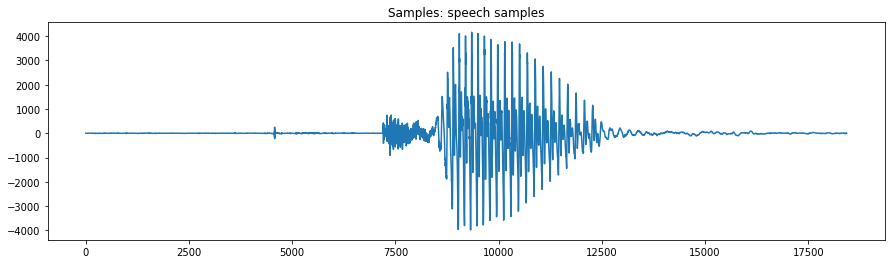

In [5]:
plt.plot(samples)
plt.title('Samples: speech samples')
plt.show()

## 1) Create frames

In [6]:
srate=int(samplingrate/1000) # samples per ms
winlen = srate*20 # samples in 20ms
winshift = srate*10
print("Each frame will include", winlen, "samples.")
emph = enframe(samples,samplingrate, winlen, winshift)


Each frame will include 400 samples.


Plot frames and make sure that the testcase is satisfied

True


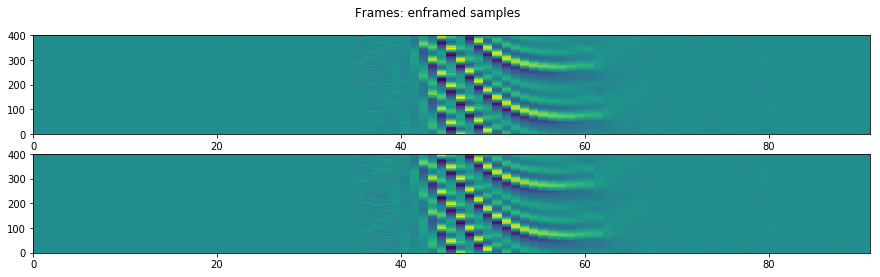

In [7]:
# Plot frames
print(np.isclose(emph,frames).all())
plt.suptitle('Frames: enframed samples')
plt.subplot(211)
plt.pcolormesh(emph.T)
plt.subplot(212)
plt.pcolormesh(frames.T)
plt.show()

## 2) Pre-emphasis

Preemphasis is done by: x[n] = x[n] - 0.97*x[n-1].

This correspond to H(z) = 1 - 0.97*z^-1


In [8]:
premph = preemp(frames)

Plot preemmph and make sure that the testcase is satisfied

True


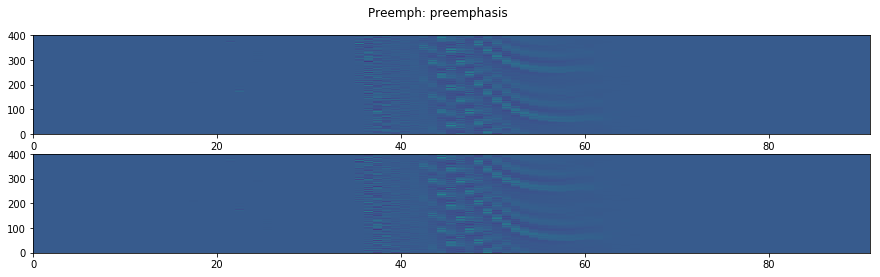

In [9]:
print(np.isclose(premph,preemph).all())
plt.suptitle('Preemph: preemphasis')
plt.subplot(211)
plt.pcolormesh(premph.T)
plt.subplot(212)
plt.pcolormesh(preemph.T)
plt.show()

## 3) Hamming Windowing

Hamming Window has similiar Form both in time and frequency domain and it has less sidelobs compared to the ideal window.

Since we do DFT the signal is assumed to be periodic with period equal to the length of the frame. Since the signal starts and ends with different values this would lead to discontinuities when the signal is repeated. By using Hamming Window we reduce those kind of artifacts as the singal after Windowing starts with 0 and ends with 0.

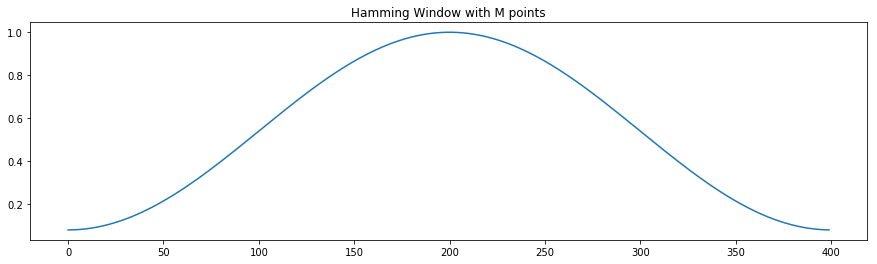

In [10]:
plt.title('Hamming Window with M points')
plt.plot(signal.hamming(preemph.shape[1],sym=False))
plt.show()

In [11]:
windowed2 = windowing(preemph)

Plot windowed and make sure that the testcase is satisfied

True


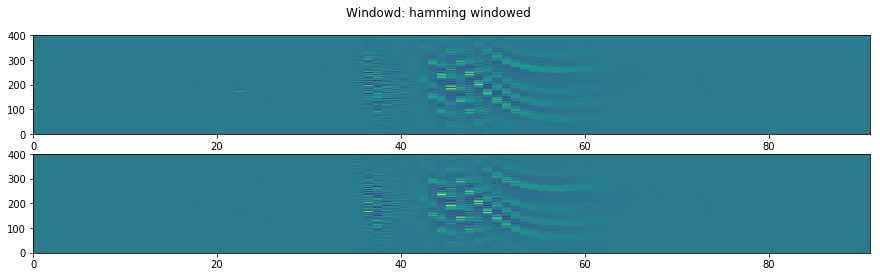

In [12]:
print(np.isclose(windowed2,windowed).all())
plt.suptitle('Windowd: hamming windowed')
plt.subplot(211)
plt.pcolormesh(windowed2.T)
plt.subplot(212)
plt.pcolormesh(windowed.T)
plt.show()

## 4) FFT

In [13]:
FFT = powerSpectrum(windowed,512)

Since the speech signal is discrete it means that the fourie transformation should be periodic with periode equal to the sampling rate. On the other hand, by limiting ourselfes to discrete FFT we force ourselves a periodic speech signal. FFT[1:n/2] contains the positive-frequency terms, and FFT[n/2:] contains the negative-frequency terms, in order of decreasingly negative. So the maximal frequency is corresponds to the index n/2.

The frequency can be calulated as:
freq = index * sampling_rate / nr_of_fft_points

In [14]:
fmax = samplingrate/2
print("fmax is:",fmax/1000,"kHz.")

fmax is: 10.0 kHz.


Plot FFT and make sure that the testcase is satisfied

True


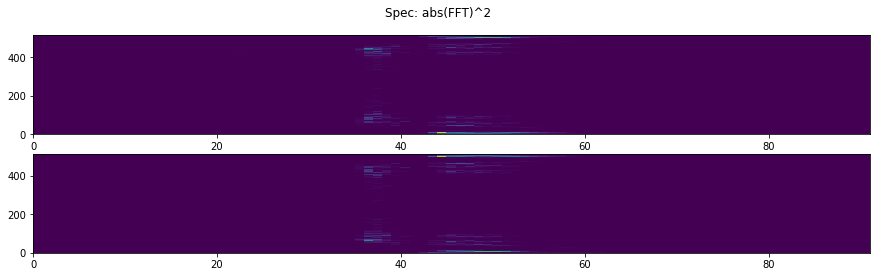

In [15]:
print(np.isclose(FFT,spec).all())
plt.suptitle('Spec: abs(FFT)^2')
plt.subplot(211)
plt.pcolormesh(FFT.T)
plt.subplot(212)
plt.pcolormesh(spec.T)
plt.show()

## 5) Filterbank

Such filters compute the average spectrum around each center frequency with increasing bandwidths.
The definition is 

       N-1
y[k] = 2* sum x[n]*cos(pi*k*(2n+1)/(2*N)), 0 <= k < N

       n=0
          
Since we sum from 0 to N for every k, the results are different when choosing N=13 and taking y[k] for the first 13 k-s and using another N not equal to 13.

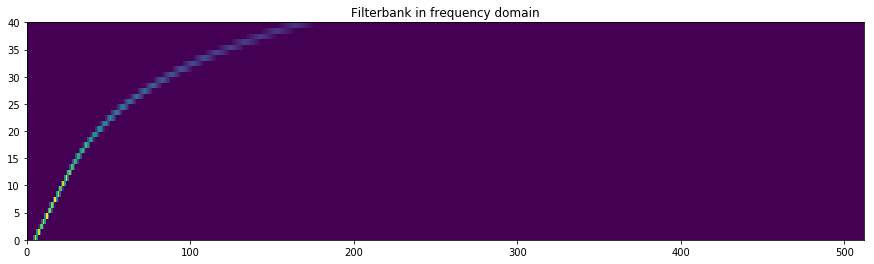

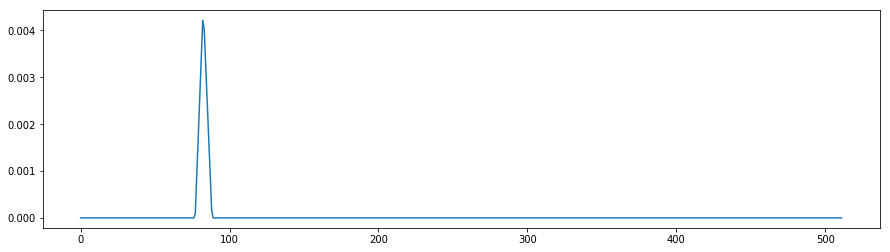

In [16]:
filterbank = trfbank(samplingrate, 512)
plt.title("Filterbank in frequency domain")
plt.pcolormesh(filterbank)
plt.show()
plt.plot(filterbank[29])
plt.show()

We get 4 features from the multiplication with filterbank in frequency domain.

In [17]:
result = logMelSpectrum(spec, samplingrate)

Plot result of filterbank and make sure that the testcase is satisfied

True


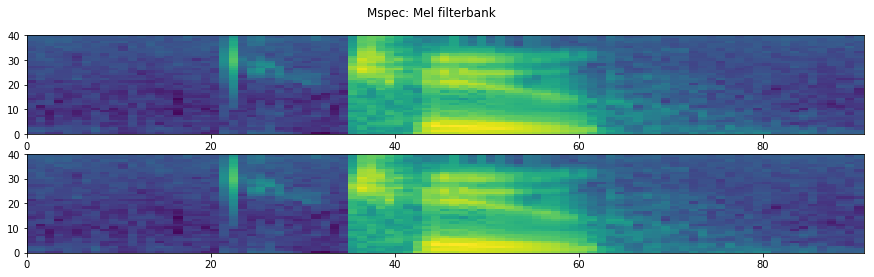

In [18]:
print(np.isclose(result,mspecc).all())
plt.suptitle('Mspec: Mel filterbank')
plt.subplot(211)
plt.pcolormesh(result.T) # is
plt.subplot(212)
plt.pcolormesh(mspecc.T) # should be 
plt.show()

## 6) CEPS

In [19]:
CEPS = cepstrum(mspecc, 13)

True


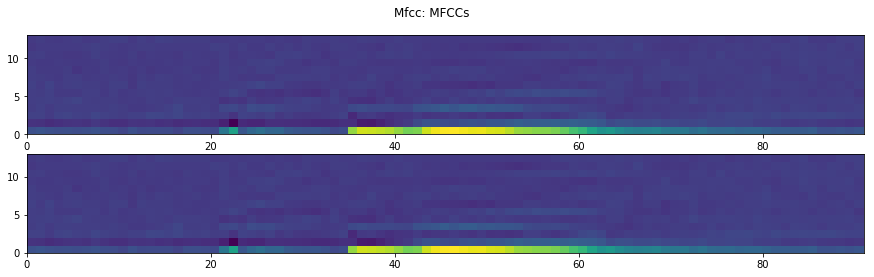

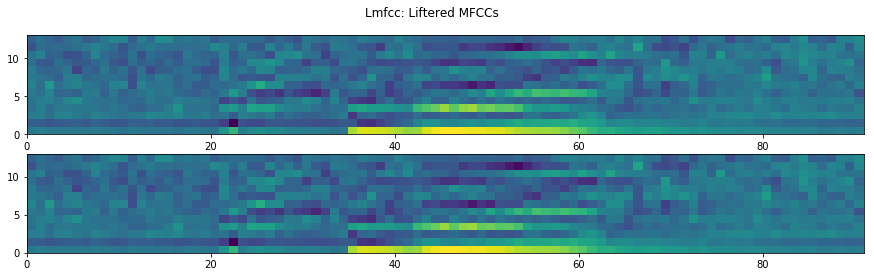

In [20]:
print(np.isclose(CEPS,mfccc).all())
plt.suptitle('Mfcc: MFCCs')
plt.subplot(211)
plt.pcolormesh(CEPS.T)
plt.subplot(212)
plt.pcolormesh(mfccc.T)
plt.show() 

# Lifted
plt.suptitle('Lmfcc: Liftered MFCCs')
plt.subplot(211)
plt.pcolormesh(lifter(CEPS).T)
plt.subplot(212)
plt.pcolormesh(lmfcc.T)
plt.show() 

# Feature Correlation

In [21]:

result = mfcc(samples)
result.shape

(91, 13)

**results** holds the feature-vectors for all frames of all samples. It is a [MxN] matrix where M is the total number of frames for all samples and N is the number of features for each frame.

In [22]:
mfcc_features=mfcc(data[0]['samples'])
mspec_features=mspec(data[0]['samples'])
print("MFCC features have dimension",mfcc_features.shape[1])
print("Mspec features have dimension",mspec_features.shape[1])


for i in range(1,len(data)):
    mfcc_features = np.vstack((mfcc_features,mfcc(data[i]['samples'])))
    mspec_features = np.vstack((mspec_features,mspec(data[i]['samples'])))

MFCC features have dimension 13
Mspec features have dimension 40


### a) Correlation of MFCC features
Since the correlation matrix is almost diagonal we may say that the features are very correlated.
This justifies the assumption for diagonal Gaussian covariances.

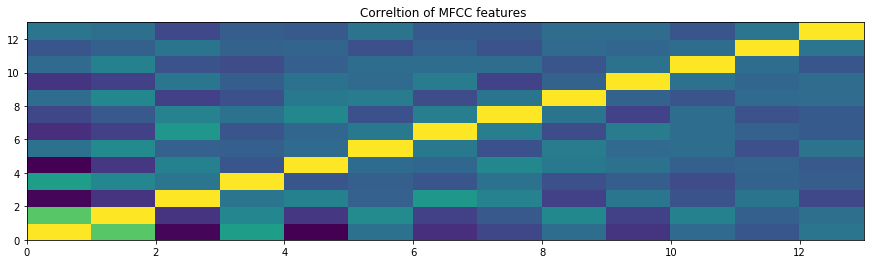

In [23]:
mfcc_corr = np.corrcoef(mfcc_features.T)

plt.title('Correltion of MFCC features ')
plt.pcolormesh(mfcc_corr)
plt.show()

### b) Correlation of MSPEC features
It is obvious from the correlation matrix that the features from the mel filterbank are much more correlated that the ones after applying the Discrete Cosine Transform.

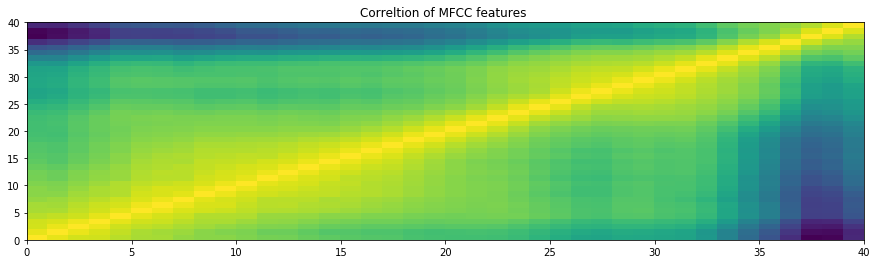

In [24]:
mspec_corr = np.corrcoef(mspec_features.T)

plt.title('Correltion of MFCC features ')
plt.pcolormesh(mspec_corr)
plt.show()

In [25]:
# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=32, covariance_type='diag')
clf.fit(mfcc_features)
print(clf.means_.shape)
Z = np.exp(clf.score_samples(mfcc_features))
print(sum(Z))

(32, 13)
1.2183593522232243e-28


### c) Posterior of data for increasing nr of GMM components

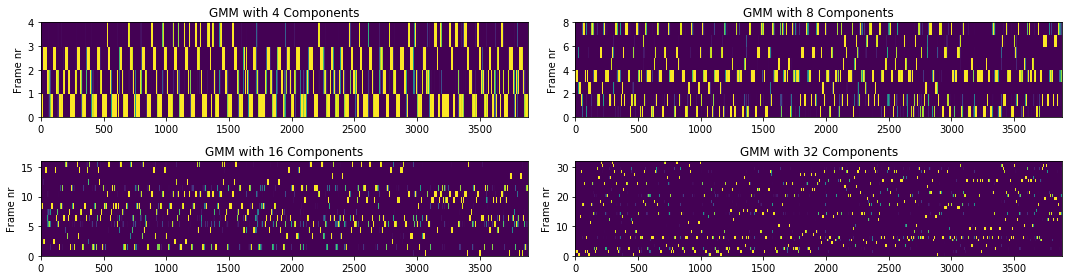

In [26]:
nr_of_comp = [4,8,16,32]

for i in range(4):
    n = nr_of_comp[i] # nr of Gaussian components
    clf = mixture.GaussianMixture(n_components=n, covariance_type='diag')
    clf.fit(mfcc_features)
    Z = clf.predict_proba(mfcc_features)
    
    plt.subplot(221+i)
    plt.ylabel('Frame nr')
    plt.title("GMM with "+str(n)+" Components")
    plt.pcolormesh(Z.T)
    #print("Sum of posteriors for all frames for a GMM with",n,"components is:",sum(Z))
plt.tight_layout() # space between plots

### d) Posteriors of seven
In this scenario we observe only data samples of utterance "seven". These utterances are given by their indexes 16,17,38 and 39 in the data dictonary. We use a GMM with 32 components. As we observe from the plots it is obvious that we can pair the utterances on two grupes of 2 elements according to their similiarity: (16,17) and (38,39).

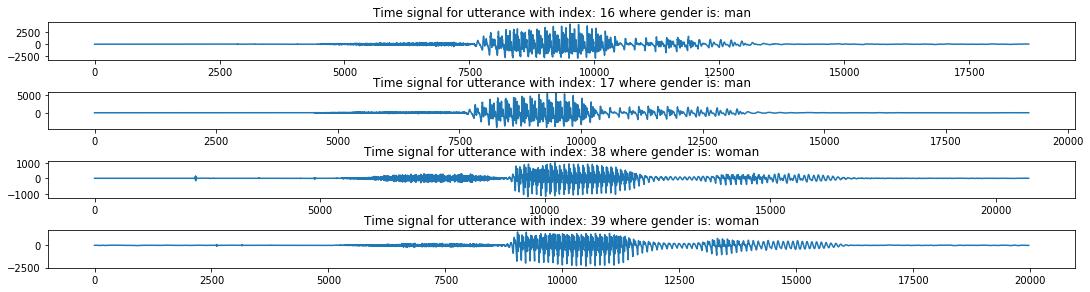

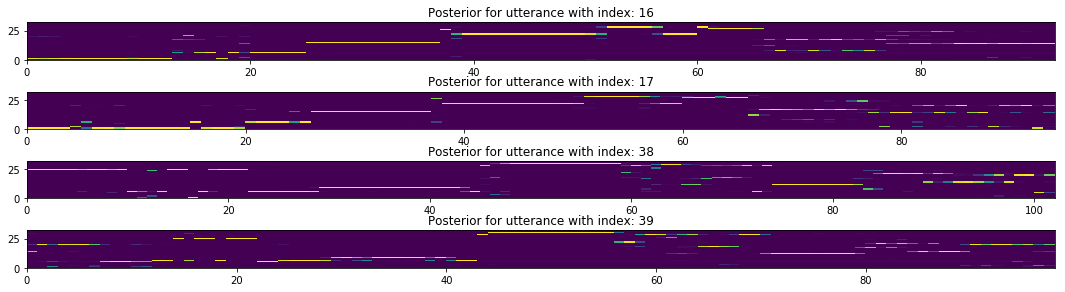

In [27]:
utt_indexes = [16,17,38,39]
seven_features = mfcc(data[16]['samples'])

fig, axes = plt.subplots(nrows=4, ncols=1)
fig.tight_layout()
for i in range(4):
    ind = utt_indexes[i]
    plt.subplot(411+i)
    plt.title("Time signal for utterance with index: "+str(ind)+" where gender is: "+str(data[ind]['gender']))
    plt.plot(data[ind]['samples'])
    
fig, axes = plt.subplots(nrows=4, ncols=1)
fig.tight_layout()
for i in range(4):
    ind = utt_indexes[i]
    seven_features = mfcc(data[ind]['samples'])
    plt.subplot(411+i)
    plt.title("Posterior for utterance with index: "+str(ind))
    plt.pcolormesh(clf.predict_proba(seven_features).T)
#plt.pcolormesh(clf.predict_proba(seven_features))

# Comparing utterances

### a) Global distance between two features
Dynamic Time Warping is used to calculate the global distance.

The shapes of the features to be compared are: (92, 13) (116, 13) .
The global distance is: 339.6824516892089


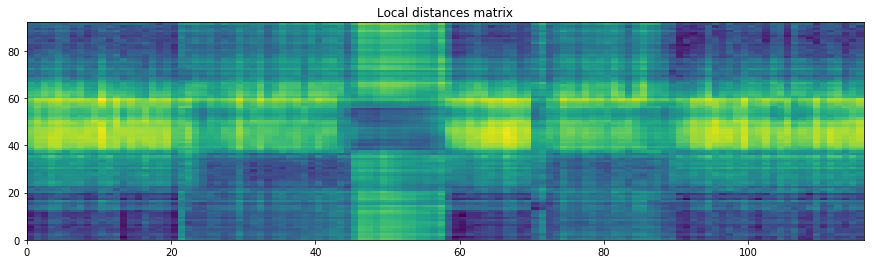

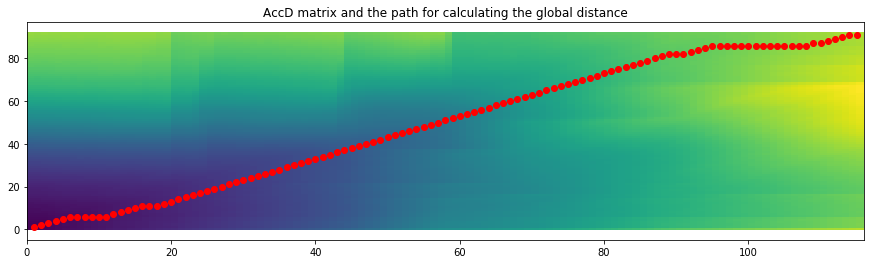

In [28]:
feature1 = mfcc(data[16]['samples'])
feature2 = mfcc(data[36]['samples'])
print("The shapes of the features to be compared are:",feature1.shape,feature2.shape,".")


d,AccD,path,LD = dtw(feature1, feature2)
print("The global distance is:", d)
plt.title('Local distances matrix')
plt.pcolormesh(LD)
plt.show()
plt.title('AccD matrix and the path for calculating the global distance')
plt.pcolormesh(AccD)
plt.scatter(np.array(path[:])[:,0],np.array(path[:])[:,1],c='red')
plt.show()

### b) The global distance for each utterance pair 
We notice from the plot that distances between the same digits are very small. In addition to that we observe that distances to the imidiate neighbors are small too. This supports the fact that distances between similiar utterances are small, e.g. distance between utterances 16,17 are small as they both correspond to seven spoken by speaker of the same gender.


But we see that this doesn't mean that distances between same digits for different speakers are small too. If that would be true the upper-left and bottom-right quarter-matrixes of the D matrix should look like diagonal matrixes(small valaues in the diagonal) since the utterances are repeated but with different gender. 

[]

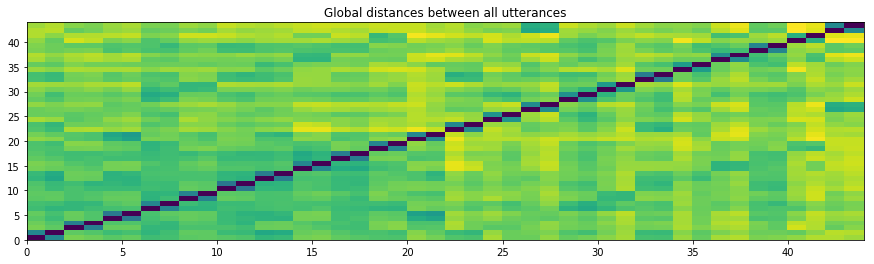

In [61]:
N = len(data)

D = np.array([dtw(mfcc(data[i]['samples']), mfcc(data[j]['samples']),onlyd=True) for i in range(N) for j in range(N)]).reshape(N,N)


plt.title('Global distances between all utterances')
plt.pcolormesh(D)
plt.plot()

/home/maxdox/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


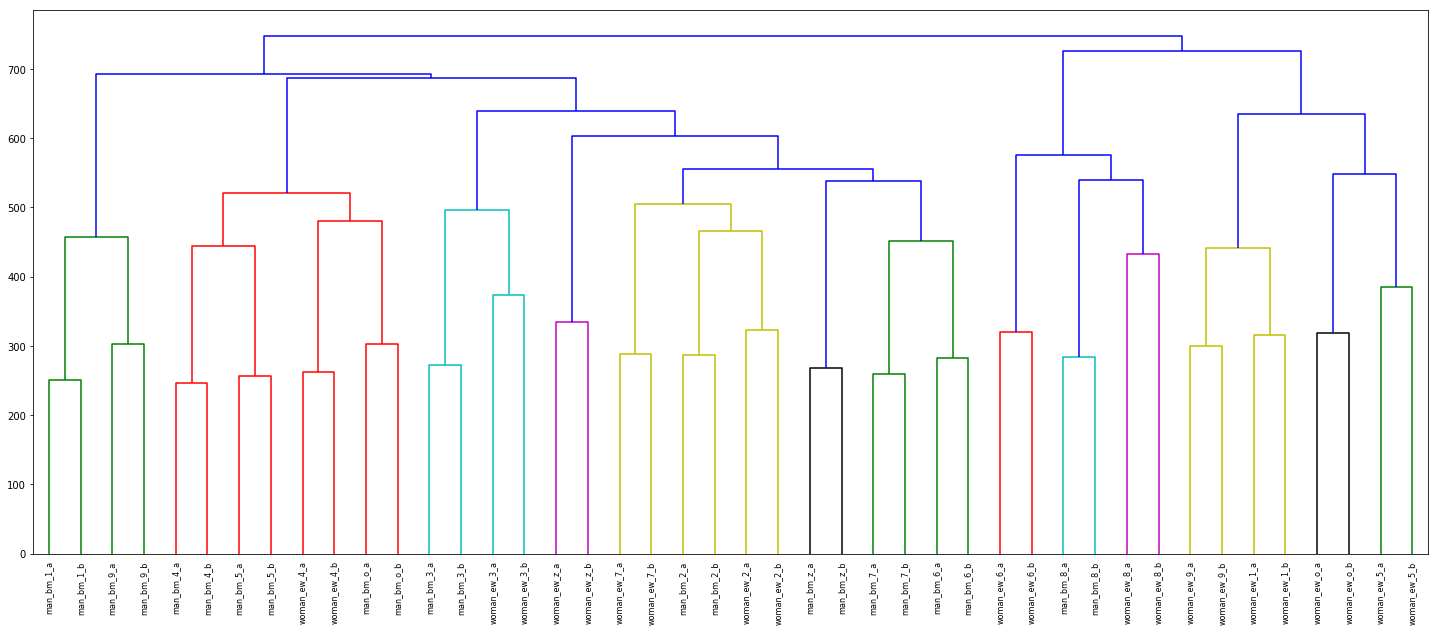

In [62]:
Z=linkage(D, method='complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z,labels=tidigit2labels(data))

In [63]:
print([i['gender'] for i in data])
print(len(data))

['man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'man', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman', 'woman']
44
